In [108]:
import pandas as pd
import numpy as np
import spacy 
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
import os
import re
import scipy 
from pyvis.network import Network

In [2]:
#spacy english language module
!python -m spacy download en_core_web_sm

     ---------------------------------------- 12.8/12.8 MB 5.7 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [44]:
#load the english module; NER stands for named entity recognition
NER = spacy.load('en_core_web_sm')
#NER.max_length = 2300000

In [37]:
#importing the books
path = r"C:\Users\Thyfus\Desktop\dataProject\GoT project\Books"

all_books = [b for b in os.scandir(path) if '.txt' in b.name]

In [38]:
#validating that all books are there

all_books

[<DirEntry '1 A Game of Thrones.txt'>,
 <DirEntry '2 A Clash of Kings.txt'>,
 <DirEntry '3 A Storm of Swords.txt'>,
 <DirEntry '4 A Feast for Crows.txt'>,
 <DirEntry '5 A Dance with Dragons.txt'>]

In [45]:
NER.max_length = len(book)

book = all_books[0]
book_text = open(book, encoding='utf-8').read()
book_doc = NER(book_text)

In [47]:
displacy.render(book_doc[0:2000], style='ent', jupyter=True)

In [50]:
#loading the characters df

characters_df = pd.read_csv('Got Characters.csv')

In [51]:
characters_df

,Unnamed: 0,name
0,0,Addam Marbrand
1,1,Addison Hill
2,2,Adrack Humble
3,3,Adrian Tarbeck
4,4,Aegon Blackfyre
...,...,...
1261,1261,Yorko Terys
1262,1262,Ysabel
1263,1263,Ysilla
1264,1264,Ysilla Royce


In [58]:
#remove the parentesis from character names in the df 
characters_df['name'] = characters_df['name'].apply(lambda x: re.sub('[\(.*?)]', '', x))
#creating a column for the first name of the characters
characters_df['first_name'] = characters_df['name'].apply(lambda x: x.split(' ', 1)[0])

In [62]:
#validating there are no 
#pd.set_option('display.max_rows', None)
characters_df

,Unnamed: 0,name,first_name
0,0,Addam Marbrand,Addam
1,1,Addison Hill,Addison
2,2,Adrack Humble,Adrack
3,3,Adrian Tarbeck,Adrian
4,4,Aegon Blackfyre,Aegon
...,...,...,...
1261,1261,Yorko Terys,Yorko
1262,1262,Ysabel,Ysabel
1263,1263,Ysilla,Ysilla
1264,1264,Ysilla Royce,Ysilla


In [63]:
#create list with named entetities per sentences

sent_entity_df = []

#loop through sentences, store named entities for each sentence

for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({'sentence': sent, 'entities': entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [64]:
#validating the output
sent_entity_df

,sentence,entities
0,"(PROLOGUE, \n\n)",[PROLOGUE\n\n]
1,"(“, We, should, start, back, ,, ”, Gared, urge...","[“We should start back,” Gared urged as the wo..."
2,"(“, The, wildlings, are, dead, ., ”, \n)",[“The wildlings are dead.”\n]
3,"(“, Do, the, dead, frighten, you, ?, ”)",[“Do the dead frighten you?”]
4,"(Ser, Waymar, Royce, asked, with, \n, just, th...",[Ser Waymar Royce asked with\njust the hint of...
...,...,...
24805,"(“, Blood, of, my, blood, ,, ”, she, heard, \n...","[“Blood of my blood,” she heard\nAggo echo.]"
24806,"(“, Blood, of, my, blood, ,, ”, Rakharo, shout...","[“Blood of my blood,” Rakharo shouted.\n]"
24807,"(And, after, them, came, her, handmaids, ,, an...","[And after them came her handmaids, and then t..."
24808,"(As, Daenerys, Targaryen, rose, to, her, feet,...","[As Daenerys Targaryen rose to her feet, her b..."


In [65]:
#create list with named entetities per sentences

sent_entity_df = []

#loop through sentences, store named entities for each sentence

# Loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [66]:
#validating the output
sent_entity_df

,sentence,entities
0,"(PROLOGUE, \n\n)",[]
1,"(“, We, should, start, back, ,, ”, Gared, urge...",[]
2,"(“, The, wildlings, are, dead, ., ”, \n)",[]
3,"(“, Do, the, dead, frighten, you, ?, ”)",[]
4,"(Ser, Waymar, Royce, asked, with, \n, just, th...",[Waymar Royce]
...,...,...
24805,"(“, Blood, of, my, blood, ,, ”, she, heard, \n...",[]
24806,"(“, Blood, of, my, blood, ,, ”, Rakharo, shout...",[]
24807,"(And, after, them, came, her, handmaids, ,, an...","[Dothraki, Dany, today, tomorrow]"
24808,"(As, Daenerys, Targaryen, rose, to, her, feet,...",[Daenerys Targaryen]


In [67]:
#filering all the non-character entities

def filter_entity(ent_list, characters_df):
    return [ent for ent in ent_list
           if ent in list(characters_df.name)
           or ent in list(characters_df.first_name)]

In [69]:
#validating if the function works
filter_entity(['Daenerys', 'sunny side eggs', '420'], characters_df)

['Daenerys']

In [70]:
#applying the function 

sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, characters_df))

In [72]:
#filtering out sentences without entities

sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]

In [73]:
#validating the output
sent_entity_df_filtered

,sentence,entities,character_entities
4,"(Ser, Waymar, Royce, asked, with, \n, just, th...",[Waymar Royce],[Waymar Royce]
22,"(”, \n, Ser, Waymar, Royce, glanced, at, the, ...",[Waymar Royce],[Waymar Royce]
45,"(Ser, Waymar, Royce, was, the, youngest, son, ...",[Waymar Royce],[Waymar Royce]
103,"(Frostfallen, leaves, \n, whispered, past, the...",[Royce],[Royce]
150,"(Ser, Waymar, Royce, came, next, ,, his, great...",[Waymar Royce],[Waymar Royce]
...,...,...,...
24749,"(The, fires, swept, over, Mirri, Maz, Duur, .)",[Mirri Maz Duur],[Mirri Maz Duur]
24752,"(And, now, the, flames, reached, her, Drogo, ,...",[Drogo],[Drogo]
24766,"(Mirri, Maz, Duur, had, fallen, silent, ., \n)",[Mirri Maz Duur],[Mirri Maz Duur]
24800,"(When, it, \n, saw, Jorah, ,, it, raised, its,...",[Jorah],[Jorah]


In [98]:
#Take only first name of characters
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] for item in x])

C:\Users\Thyfus\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [99]:
#looking for relationships between characters by scanning the text 
windows_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i + 5, sent_entity_df_filtered.index[-1]) #this will avoid an out of range error in case i+5 exceeds the last row of the df 
    char_list = sum((sent_entity_df_filtered.loc[i:end_i].character_entities),[]) #storing the entities that appear in the window size by calling a sum function and merging the list with an empty one
    
    #remove duplicated characters in the same sentence
    #check if it's the first time the character appears in the sentence or if the character it's not same as the one that appeared before
    unique_char = [char_list[i] for i in range(len(char_list)) if (i==0) or char_list[i] != char_list[i-1]]
    
    #checking if there is more than one character
    if len(unique_char) > 1:
        #look at each character that appears in the window and create a df with the relationship between then
        for idx, a in enumerate(unique_char[:-1]): #iterating until the second last character to not exceed the index of the list
            b = unique_char[idx + 1]
            relationships.append({'source': a, 'target': b})

In [100]:
relationships_df = pd.DataFrame(relationships)

In [101]:
#validating the output
relationships_df
#there appears to be an error with the character Waymar Royce

,source,target
0,Royce,Waymar
1,Royce,Waymar
2,Bran,Eddard
3,Eddard,Theon
4,Bran,Eddard
...,...,...
5948,Mirri,Drogo
5949,Mirri,Drogo
5950,Jorah,Jhogo
5951,Jorah,Jhogo


In [102]:
#aggregating all the duplicated relationships, this will include reverser relationships; Eddard Stark	Bran and Bran	Eddard Stark for example

#sort the df to identify the duplicates
relationships_df = pd.DataFrame(np.sort(relationships_df.values, axis=1), columns = relationships_df.columns)

In [103]:
#validating the output
#pd.set_option('display.max_rows', none)
relationships_df

,source,target
0,Royce,Waymar
1,Royce,Waymar
2,Bran,Eddard
3,Eddard,Theon
4,Bran,Eddard
...,...,...
5948,Drogo,Mirri
5949,Drogo,Mirri
5950,Jhogo,Jorah
5951,Jhogo,Jorah


In [104]:
relationships_df['value'] = 1 #adding a weight to the relation ship
relationships_df = relationships_df.groupby(['source', 'target'], sort=False, as_index=False).sum() #summing up all the weights of the relationships

In [105]:
#validating the output
relationships_df

,source,target,value
0,Royce,Waymar,2
1,Bran,Eddard,3
2,Eddard,Theon,6
3,Jory,Theon,7
4,Bran,Theon,24
...,...,...,...
693,Catelyn,Marq,4
694,Catelyn,Renly,1
695,Aegon,Maege,3
696,Drogo,Jhogo,5


In [106]:
#creating the visualization of the relationship_df
#this is a simplistic model so the only edge attribute to take into account will be the value column of the data frame
V = nx.from_pandas_edgelist(relationships_df, source='source', target='target', edge_attr='value', create_using = nx.Graph()) 

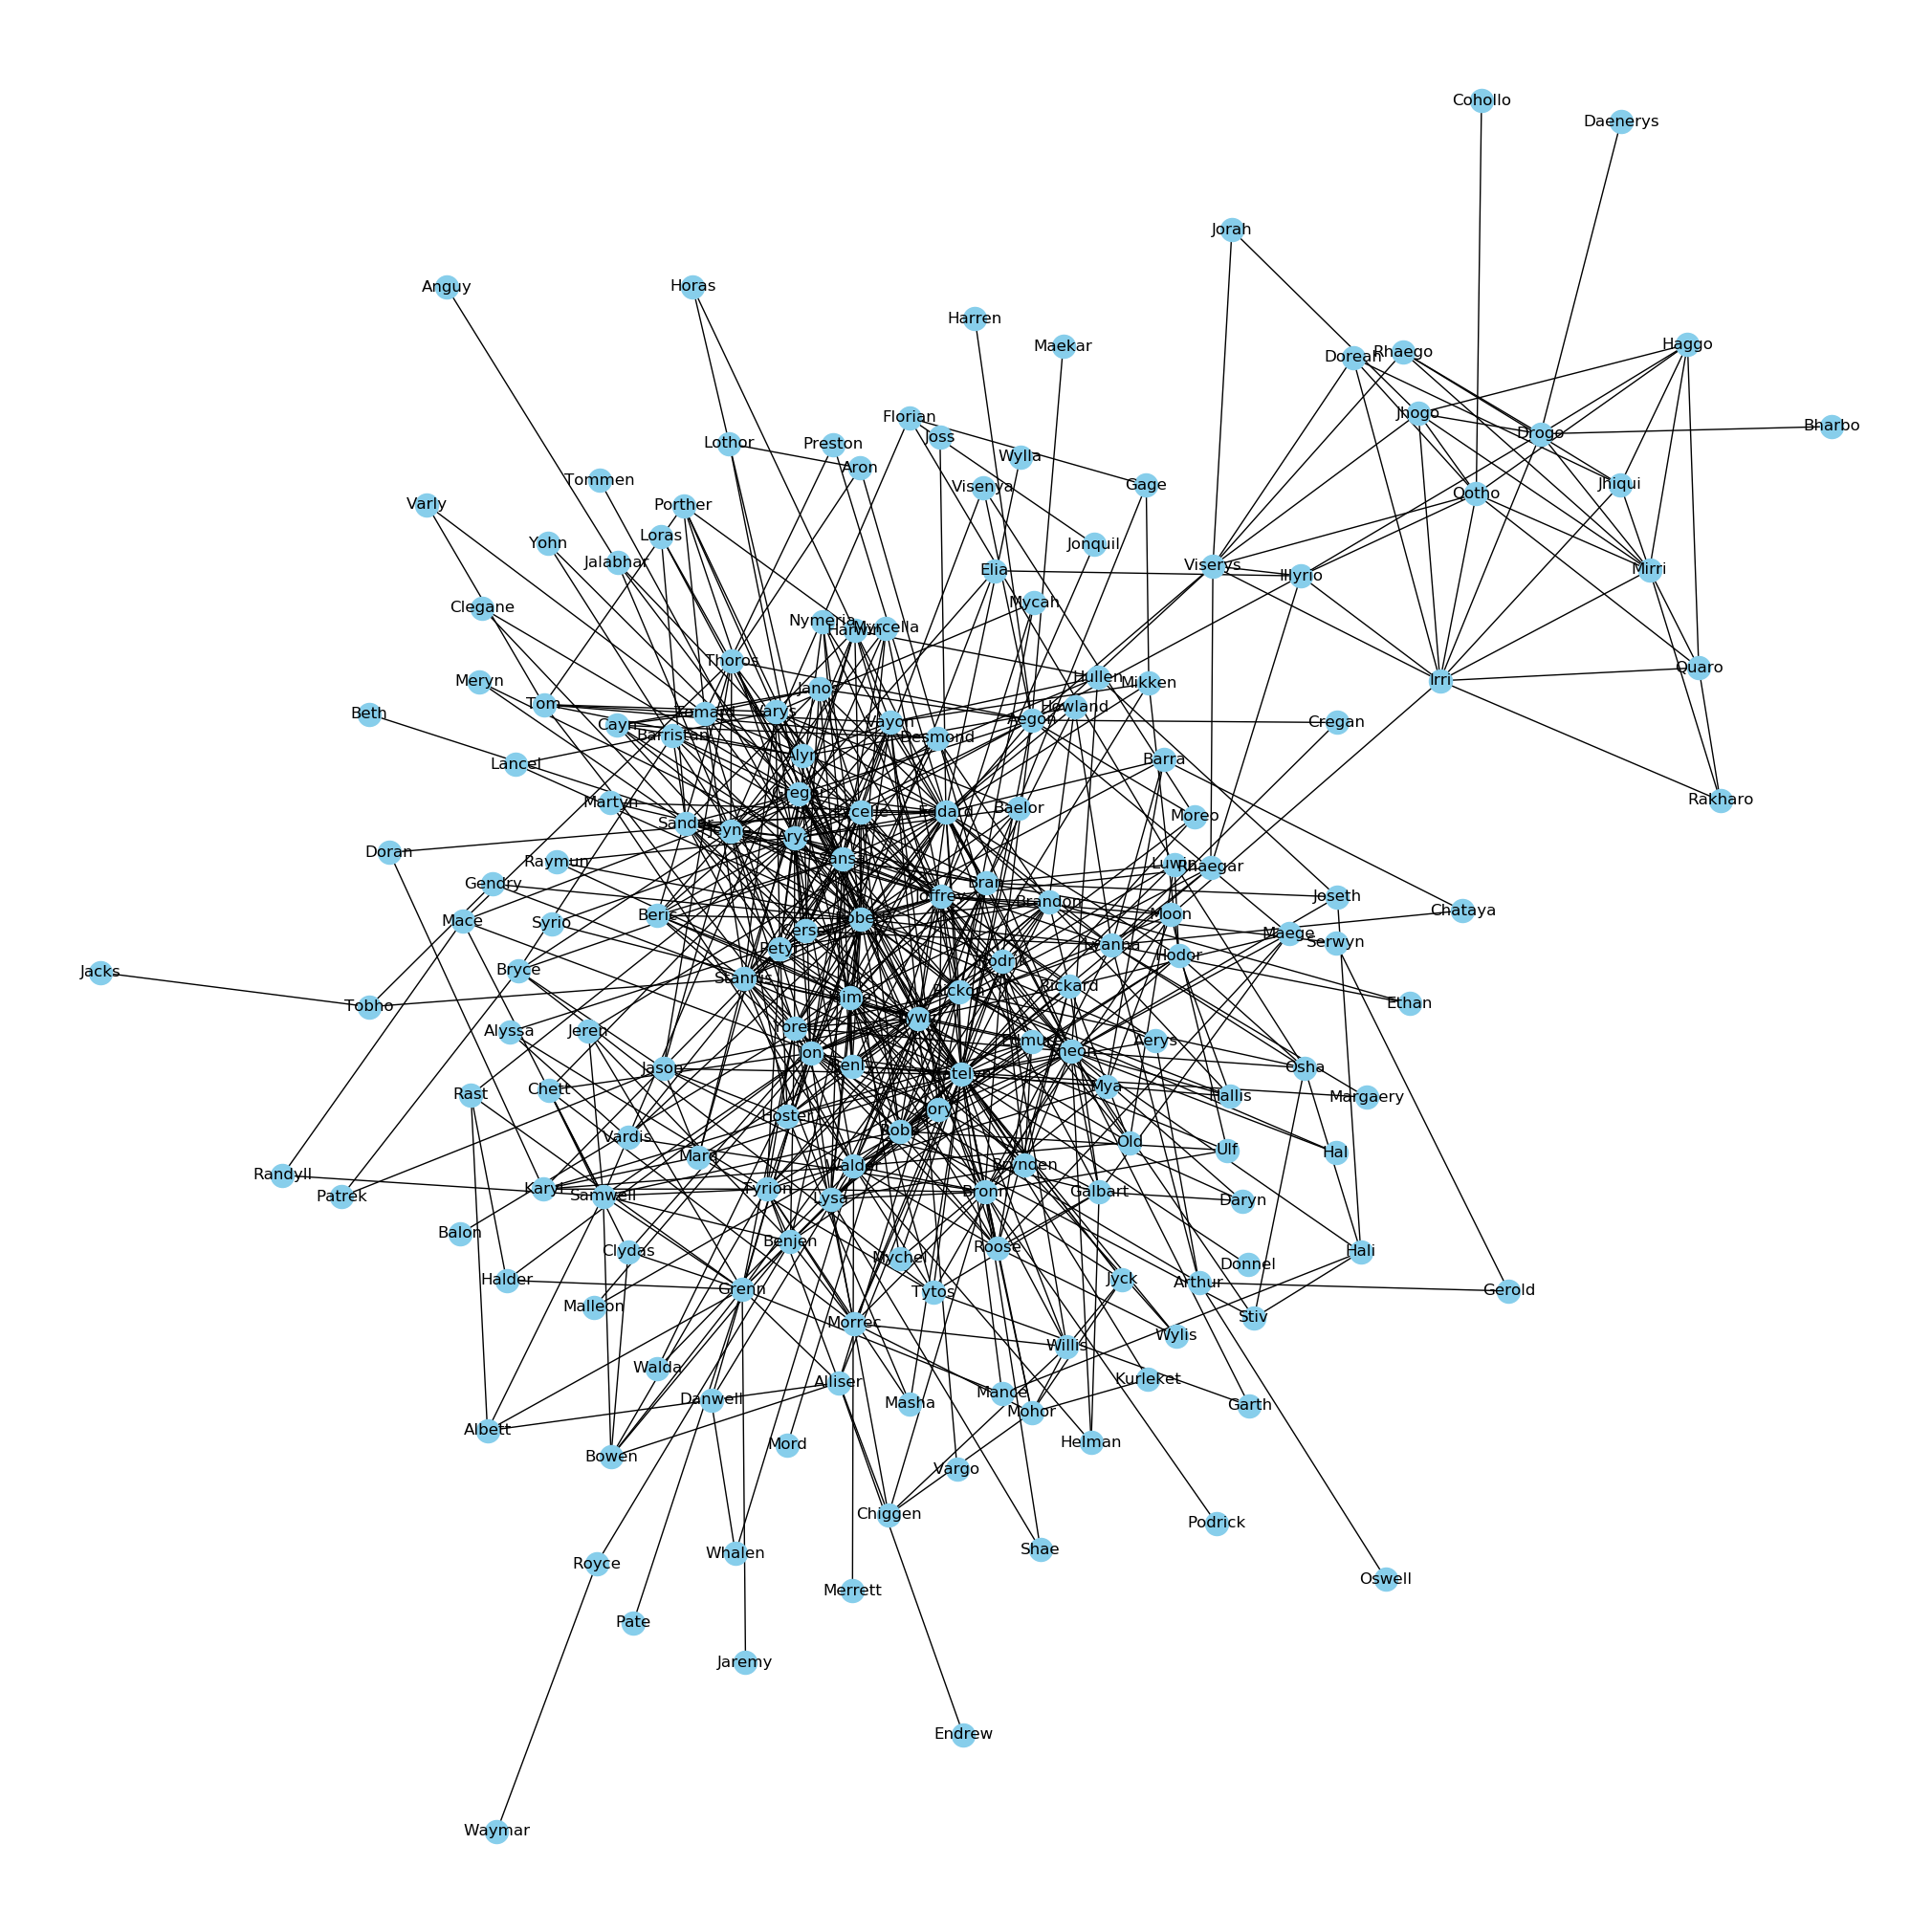

In [107]:
plt.figure(figsize=(20,20))
pos = nx.kamada_kawai_layout(V) #I like how this one looks... spoilers to many characters so it looks horrible
nx.draw(V, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

In [114]:
#using pyvis to make the visualization bearable to the eyes
net = Network(notebook=True, width='2000px', height='1400px', bgcolor='#222222', font_color='white')

#sizing the nodes by their degrees (how many conections they have)
node_degree = dict(V.degree)
nx.set_node_attributes(V, node_degree, 'size')

#pyvis interfaces with network X
net.from_nx(V)
net.show('GOT.html')
#still looks horrible and it's jittering *sigh*